In [34]:
# IMPORTS
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
from skimage import color
from skimage import io

In [35]:

drive = True

if drive:
    from google.colab import drive
    # MOUNT DRIVE
    drive.mount('/content/drive')
    data_path = '/content/drive/My Drive/DeepLearning_2023/Final/Data/'
    raw_data_path = '/content/drive/My Drive/DeepLearning_2023/Final/Data/raw_samples/'
    synth_data_path = '/content/drive/My Drive/DeepLearning_2023/Final/Data/synth_samples/'
    results_path = '/content/drive/My Drive/DeepLearning_2023/Final/Results/'
else: # LOCAL
    data_path = './Data/'
    raw_data_path = './Data/raw_samples/'
    results_path = './Results/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# UTILS
def one_hot_encode_multiple_classes(array, n_classes=36):
    output = [0]*(len(array)*n_classes)
    for i, _class in enumerate(array):
        output[(i)*(n_classes) + (_class)] = 1
    return output

def one_hot_decode_multiple_classes(one_hot, n_classes=36):
    length = len(one_hot)//n_classes
    output = [0]*length
    for i in range(length):
        _class = np.argmax(one_hot[(i*n_classes):((i+1)*n_classes)])
        output[i] = _class
    return output

def single_character_to_int(c): # Converts char to int label
    if c.isdigit():
        return int(c)
    else:
        return int(ord(c) - 87)

def all_character_to_int(array):
    output = []
    for i in array:
      output.append(single_character_to_int(i))
    return output

def int_to_single_character(i): # Converts int label to char
    if i<10:
        return str(int(i))
    else:
        return str(chr(int(i) + 87))

def int_to_all_character(array):
    output = []
    for i in array:
      output.append(int_to_single_character(i))
    return output

def squareImage(img, target_size = 192): # INPUT IMG MUST BE PIL IMAGE RGBA: RETURNS NUMPY ARRAY OF SIZE 192x192x4
    if img.mode == "RGBA":
        channels = 4
    elif img.mode == "RGB":
        channels = 3
    else:
        print("Image with wrong mode")
    img_np = np.array(img.getdata()).reshape(img.size[1], img.size[0], channels)
    #PADDING
    y,x,_ = img_np.shape
    pad_y = max(0, (target_size - y)//2)
    pad_x = max(0, (target_size - x)//2)
    img_np = np.pad(img_np, ((pad_y, pad_y),(pad_x, pad_x),(0, 0)), "edge")
    # CROPPING
    y,x,_ = img_np.shape
    startx = x//2-(target_size//2)
    starty = y//2-(target_size//2)
    img_np = img_np[starty:starty+192,startx:startx+192]
    return img_np

In [37]:
#CaptchaDataset class
class CaptchaDataset(torch.utils.data.Dataset):
    #characters = ['a''b''c''d''e''f''g''h''i''j''k''l''m''n''o''p''q''r''t''u''v''w''x''y''z']
    #numbers = ['1''2''3''4''5''6''7''8''9''10''11''12''13''14''15''16''17''18''19''20''21''22''23''24']
    # Initialization method for the dataset
    def __init__(self, dataPath = raw_data_path, transform = None):
        self.data = []
        self.labels = []
        directory_files = os.listdir(dataPath)
        for filename in directory_files:
            self.data.append(np.array(squareImage(Image.open(dataPath+filename)))[:,:,0])
            #self.data.append(np.array(Image.open(dataPath+filename))[:,:,0])
            #self.labels.append(filename[:-4])
            self.labels.append(all_character_to_int(filename[0:5]))
        self.data=np.array(self.data)
        self.transform = transform

    # What to do to load a single item in the dataset ( read image and label)
    def __getitem__(self, index):
        data = self.data[index]
        lbl =  torch.Tensor(self.labels[index])
        data = Image.fromarray((data).astype(np.uint8))
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None :
            data = self.transform(data)

        # return the image and the label
        return data,lbl

    # Return the number of images
    def __len__(self):
        return self.data.shape[0]

In [38]:
#CaptchaDataset class
class CaptchaDataset(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self, dataPath = raw_data_path, transform = None):
        self.data = []
        self.labels = []
        directory_files = os.listdir(dataPath)
        for filename in directory_files:
            self.data.append(np.array(squareImage(Image.open(dataPath+filename)))[:,:,0])
            self.labels.append(all_character_to_int(list(filename[:5])))
        self.data=np.array(self.data)
        self.transform = transform

    # What to do to load a single item in the dataset ( read image and label)
    def __getitem__(self, index):
        data = self.data[index]
        lbl = torch.Tensor(self.labels[index])
        data = Image.fromarray((data).astype(np.uint8))
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None :
            data = self.transform(data)

        # return the image and the label
        return data,lbl

    # Return the number of images
    def __len__(self):
        return self.data.shape[0]

In [39]:
# Image transformer
tr = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = [.5], std = [.5])
        ])

#Instantiating captchaDataset
captchaDataset = CaptchaDataset(raw_data_path, tr)
print("captchaDataset created:")
print(" ", len(captchaDataset), "images")
print(" ", captchaDataset.data.shape)

# Setting train and test sizes
train_size = int(len(captchaDataset) * 0.7)
test_size = len(captchaDataset) - train_size

# Dataset splitting (inputs Dataset and outputs a dataset.Subset (which has same properties and methods as Dataset)))
train_set, test_set = torch.utils.data.random_split(captchaDataset,[train_size,test_size])
print("Dataset splitted:")
print("  Training set len:", len(train_set))
print("  Testing set len:", len(test_set))

captchaDataset created:
  1080 images
  (1080, 192, 192)
Dataset splitted:
  Training set len: 756
  Testing set len: 324


tensor([23.,  8., 15., 25.,  6.])
['n', '8', 'f', 'p', '6']


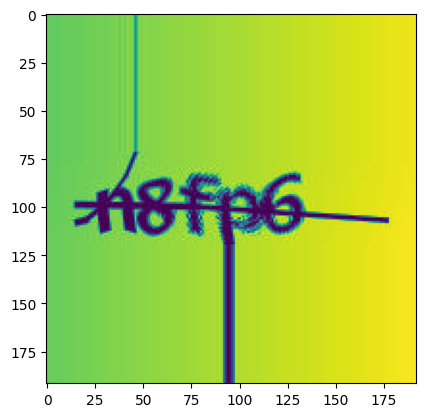

In [40]:
# Dataset sample example
data, lbl = captchaDataset.__getitem__(250)
plt.imshow(data.numpy()[0])
print(lbl)
print(int_to_all_character(lbl.numpy().tolist()))

In [41]:
class MyMobileNetV2(nn.Module):
    def __init__(self, num_classes=36):
        super(MyMobileNetV2, self).__init__()



        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout(0.05)
        t = 1
        self.conv20 = nn.Conv2d(16, 16*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn20 = nn.BatchNorm2d(16*t)
        self.conv21 = nn.Conv2d(16*t, 16, kernel_size=3, stride=1, padding=1, groups=16, bias=False)
        self.bn21 = nn.BatchNorm2d(16)
        self.conv22 = nn.Conv2d(16, 32, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn22 = nn.BatchNorm2d(32)

        t = 6
        self.conv30 = nn.Conv2d(32, 32*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn30 = nn.BatchNorm2d(32*t)
        self.conv31 = nn.Conv2d(32*t, 32, kernel_size=3, stride=1, padding=1, groups=32, bias=False)
        self.bn31 = nn.BatchNorm2d(32)
        self.conv32 = nn.Conv2d(32, 64, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn32 = nn.BatchNorm2d(64)

        self.conv40 = nn.Conv2d(64, 64*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn40 = nn.BatchNorm2d(64*t)
        self.conv41 = nn.Conv2d(64*t, 64, kernel_size=3, stride=1, padding=1, groups=64, bias=False)
        self.bn41 = nn.BatchNorm2d(64)
        self.conv42 = nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn42 = nn.BatchNorm2d(128)
        self.dropout4 = nn.Dropout(0.05)

        self.conv50 = nn.Conv2d(128, 128*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn50 = nn.BatchNorm2d(128*t)
        self.conv51 = nn.Conv2d(128*t, 128, kernel_size=3, stride=1, padding=1, groups=128, bias=False)
        self.bn51 = nn.BatchNorm2d(128)
        self.conv52 = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn52 = nn.BatchNorm2d(128)

        self.conv60 = nn.Conv2d(128, 128*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn60 = nn.BatchNorm2d(128*t)
        self.conv61 = nn.Conv2d(128*t, 128, kernel_size=3, stride=1, padding=1, groups=128, bias=False)
        self.bn61 = nn.BatchNorm2d(128)
        self.conv62 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn62 = nn.BatchNorm2d(256)


        self.conv70 = nn.Conv2d(256, 256*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn70 = nn.BatchNorm2d(256*t)
        self.conv71 = nn.Conv2d(256*t, 256, kernel_size=3, stride=1, padding=1, groups=256, bias=False)
        self.bn71 = nn.BatchNorm2d(256)
        self.conv72 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn72 = nn.BatchNorm2d(256)
        self.dropout7 = nn.Dropout(0.05)

        self.conv80 = nn.Conv2d(256, 256*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn80 = nn.BatchNorm2d(256*t)
        self.conv81 = nn.Conv2d(256*t, 256, kernel_size=3, stride=1, padding=1, groups=256, bias=False)
        self.bn81 = nn.BatchNorm2d(256)
        self.conv82 = nn.Conv2d(256, 512, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn82 = nn.BatchNorm2d(512)

        t = 1
        self.conv90 = nn.Conv2d(512, 512*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn90 = nn.BatchNorm2d(512*t)
        self.conv91 = nn.Conv2d(512*t, 512, kernel_size=3, stride=1, padding=1, groups=256, bias=False)
        self.bn91 = nn.BatchNorm2d(512)
        self.conv92 = nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn92 = nn.BatchNorm2d(512)

        self.relu6 = nn.ReLU6(inplace=True)
        self.MaxPool2d= nn.MaxPool2d(kernel_size=2, stride=2)
        self.AvgPool2d = nn.AvgPool2d(6,stride=6)
        #self.fc1 = nn.Linear(512, 256)
        self.dropoutFc = nn.Dropout(0.1)
        #self.fc2 = nn.Linear(256, num_classes)
        #self.fc = nn.Linear(512, num_classes*5*40)

        #self.lstm = nn.LSTM( 4*4*512, hidden_size=num_classes*5*20, bidirectional=True)
        self.densities = nn.ModuleList([nn.Linear(512*4, 128) for _ in range(5)])
        self.dropout2 = nn.Dropout(0.05)
        self.predictions = nn.ModuleList([nn.Linear(128, num_classes) for _ in range(5)])

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear) or  isinstance(m, nn.Conv2d):
           nn.init.xavier_uniform_(m.weight)
    def forward(self, x):

        #print(x.shape) -> INPUT: (192, 192, 1)
        out = self.relu6(self.bn1(self.conv1(x))) #-> OUTPUT: (192, 192, 16)
        out = self.dropout1(out)
        out = self.relu6(self.bn22(self.conv22(self.relu6(self.bn21(self.conv21(self.relu6(self.bn20(self.conv20(out))))))))) #-> OUTPUT: (192, 192, 32)
        out = self.MaxPool2d(out) #-> OUTPUT: (96, 96, 32)
        out = self.relu6(self.bn32(self.conv32(self.relu6(self.bn31(self.conv31(self.relu6(self.bn30(self.conv30(out))))))))) #-> OUTPUT: (96, 96, 64)
        out = self.relu6(self.bn42(self.conv42(self.relu6(self.bn41(self.conv41(self.relu6(self.bn40(self.conv40(out))))))))) #-> OUTPUT: (96, 96, 128)
        out = self.dropout4(out)
        out = self.MaxPool2d(out) #-> OUTPUT: (48, 48, 128)
        out = self.relu6(self.bn52(self.conv52(self.relu6(self.bn51(self.conv51(self.relu6(self.bn50(self.conv50(out)))))))))+out  #-> OUTPUT: (48, 48, 128)
        out = self.relu6(self.bn62(self.conv62(self.relu6(self.bn61(self.conv61(self.relu6(self.bn60(self.conv60(out)))))))))  #-> OUTPUT: (48, 48, 256)
        out = self.relu6(self.bn72(self.conv72(self.relu6(self.bn71(self.conv71(self.relu6(self.bn70(self.conv70(out)))))))))+out #-> OUTPUT: (48, 48, 256)
        out = self.dropout7(out)
        out = self.MaxPool2d(out) #-> OUTPUT: (24, 24, 256)
        out = self.relu6(self.bn82(self.conv82(self.relu6(self.bn81(self.conv81(self.relu6(self.bn80(self.conv80(out))))))))) #-> OUTPUT: (24, 24, 512)
        out = self.MaxPool2d(out) #-> OUTPUT: (12, 12, 512)
        out = self.relu6(self.bn92(self.conv92(self.relu6(self.bn91(self.conv91(self.relu6(self.bn90(self.conv90(out))))))))) #-> OUTPUT: (12, 12, 512)
        out = self.AvgPool2d(out) #-> OUTPUT: (1, 1, 512)
        #out = self.fc1(out)
        #out = self.fc2(out)
        out = self.dropoutFc(out)
        #out = self.fc(out)
        #print("1",out.shape)
        #out, _ = self.lstm(out)
        #print("2",out.shape)
        out = torch.flatten(out, 1)
        # Aplicar dropout al tensor resultante
        #out = self.dropoutFc(out)
        #outs=[]

        FinalOut = self.densities[0](out)
        FinalOut = self.dropout2(FinalOut)
        FinalOut = self.predictions[0](FinalOut)

        for i in range(1, 5):
            Out = self.densities[i](out)
            Out = self.dropout2(Out)
            Out = self.predictions[i](Out)
            FinalOut = torch.cat((FinalOut, Out), 1)

        return FinalOut



In [42]:
# Train function
def train(CNN, train_loader, optimizer, num_epochs=5, model_name='model.ckpt', device='cpu', test_loader=None):
    CNN.train() # Set the model in train mode
    total_step = len(train_loader)
    maxloss= 10000000
    losses_list = []
    accuracies = []
    full_accuracies = []
    criterion = nn.CrossEntropyLoss()
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_avg = 0
        nBatches = 0

        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)

            # Forward pass
            outputs = CNN(images)
            loss = 0
            for j, output in enumerate(outputs):
              label = labels[:,j].type(torch.LongTensor).to(device)
              #print(label.shape)
              loss += criterion(output, label)

              # Backward and optimize

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_avg += loss.cpu().item()
            nBatches+=1
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))

        losses_list.append(loss_avg / nBatches)

        if test_loader != None:
            CNN.eval()
            acc, full_acc = test(CNN, test_loader)
            accuracies.append(acc)
            full_accuracies.append(full_acc)
            print("Single char accuracy: {:.4f}% | Full string accuracy: {:.4f}%".format(acc, full_acc))
            CNN.train()
        if loss<maxloss:
            torch.save(CNN.state_dict(), results_path+ '/' + model_name)
            maxloss = loss
        #torch.save(CNN.state_dict(), results_path+ '/' + model_name)

    return losses_list


# Test funcion
def test(CNN, test_loader, display_errors=False):
    CNN.eval()
    with torch.no_grad():
            correct = 0
            correct_full_words = 0
            total = 0
            total_full_words = 0
            for images, labels in test_loader:
                images = images.to(device)

                # get network predictions


                # get predicted class
                #_, predicted = torch.max(outputs.data, 1)

                # compare with the ground-truth
                #print(outputs)
                outputs = CNN(images)
                for i, output in enumerate(outputs):

                  _, predicted = torch.max(output.data, 1)
                  predicted = predicted.to(device)
                  label = labels[:,i].to(device)
                  total += labels.size(0) * labels.size(1)
                  total_full_words += labels.size(0)
                  correct += (predicted == label).sum().item()
                  correct_full_words += (predicted == label).prod().sum().item()
                  #print(predicted)
                  #print(label)

                if display_errors:
                    for i in range(max(5, len(labels))):
                        if predicted[i] != labels[i]:
                            print('Real label: ' + str(labels[i]))
                            print('Predicted label: ' + str(predicted[i]))
                            print(display(plt.imshow(images[i][0].cpu().numpy())))
                            plt.show()
            # return accuracy
            return 100*correct/total, 100*correct_full_words/total_full_words

In [43]:
# Train function
def train(CNN, train_loader, optimizer, num_epochs=5, model_name='model.ckpt', device='cpu', test_loader=None):
    CNN.train() # Set the model in train mode
    total_step = len(train_loader)
    losses_list = []
    accuracies = []
    full_accuracies = []
    criterion = nn.CrossEntropyLoss()
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_avg = 0
        nBatches = 0
        maxloss = 100000
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)

            # Forward pass
            outputs = CNN(images)
            batch_size = len(outputs)
            outputs = torch.reshape(outputs, (batch_size, 36, 5))
            outputs = outputs.to(device)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_avg += loss.cpu().item()
            nBatches+=1
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        losses_list.append(loss_avg / nBatches)
        if test_loader != None:
            CNN.eval()
            acc, full_acc = test(CNN, test_loader)
            accuracies.append(acc)
            full_accuracies.append(full_acc)
            print("Single char accuracy: {:.4f}% | Full string accuracy: {:.4f}%".format(acc, full_acc))
            CNN.train()
        if maxloss>loss:
          torch.save(CNN.state_dict(), results_path+ '/' + model_name)
          maxloss = loss

    return losses_list, accuracies, full_accuracies

# Test funcion
def test(CNN, test_loader, display_errors=False):
    CNN.eval()
    with torch.no_grad():
            correct = 0
            correct_full_words = 0
            total = 0
            total_full_words = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                # get network predictions
                outputs = CNN(images)
                batch_size = len(outputs)
                outputs = torch.reshape(outputs, (batch_size, 36, 5))
                # get predicted class
                _, predicted = torch.max(outputs.data, 1)
                # compare with the ground-truth
                total += labels.size(0) * labels.size(1)
                total_full_words += labels.size(0)
                correct += (predicted == labels).sum().item()
                correct_full_words += (predicted == labels).prod(dim=1).sum().item()

            # return accuracy
            return 100*correct/total, 100*correct_full_words/total_full_words

In [44]:
#Train MyModel
model = MyMobileNetV2(num_classes=36)

#Initialize optimizer
learning_rate = .003
#optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate,
                            #weight_decay=1e-5, momentum=0.85)

optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)



device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                               batch_size=32,
                                               shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                               batch_size=256,
                                               shuffle=True)

losses_list = train(model, train_loader, optimizer, num_epochs=150, device=device, test_loader=test_loader, model_name="1cnn_5fc.ckpt")


Epoch [1/150], Step [24/24], Loss: 5.0201
Single char accuracy: 4.3210% | Full string accuracy: 0.0000%
Epoch [2/150], Step [24/24], Loss: 3.0621
Single char accuracy: 5.9877% | Full string accuracy: 0.0000%
Epoch [3/150], Step [24/24], Loss: 2.8917
Single char accuracy: 7.0988% | Full string accuracy: 0.0000%
Epoch [4/150], Step [24/24], Loss: 2.7384
Single char accuracy: 9.4444% | Full string accuracy: 0.0000%
Epoch [5/150], Step [24/24], Loss: 2.5727
Single char accuracy: 13.8272% | Full string accuracy: 0.0000%
Epoch [6/150], Step [24/24], Loss: 2.3949
Single char accuracy: 9.0741% | Full string accuracy: 0.0000%
Epoch [7/150], Step [24/24], Loss: 2.2433
Single char accuracy: 18.5185% | Full string accuracy: 0.0000%
Epoch [8/150], Step [24/24], Loss: 2.0482
Single char accuracy: 9.1975% | Full string accuracy: 0.0000%
Epoch [9/150], Step [24/24], Loss: 1.8787
Single char accuracy: 16.7284% | Full string accuracy: 0.3086%
Epoch [10/150], Step [24/24], Loss: 1.7272
Single char accura

In [45]:
# Compute model paramters
def compute_model_params(model):
  params = 0
  for p in model.parameters():
    params+= p.numel()
  return params
print("Parametres:",compute_model_params(model))

Parametres: 3203572


In [48]:
# Show results for all the trained models
test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                               batch_size=32,
                                               shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

my_net = MyMobileNetV2()
my_net.load_state_dict(torch.load(results_path + '1cnn_5fc.ckpt'))
my_net.cuda()
acc,full_acc = test(model, test_loader, display_errors=False)
print('Accuracy single characters: ' + str(round(acc, 3)) + "%")
print('Accuracy full words       : ' + str(round(full_acc, 3)) + "%")

Accuracy single characters: 97.222%
Accuracy full words       : 87.346%


tensor([ 3., 14., 23., 34.,  7.])
torch.Size([1, 1, 192, 192])


IndexError: ignored

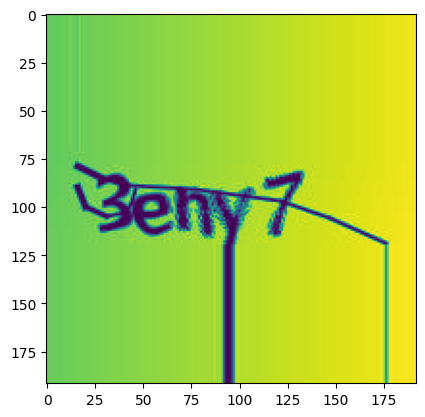

In [47]:
inputs, classes = next(iter(test_loader))
plt.imshow(inputs[0].numpy()[0])
print(classes[0])
inputs = inputs[0:1].to(device)
print(inputs.shape)
outs = my_net(inputs)
for out in outs:
  _, predicted = torch.max(out, 1)
  #print(out[0, classes[0]])
  print("Predicted: ", int_to_single_character(predicted.cpu().numpy()[0]))
  #print(out.cpu().detach().numpy())